In [55]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score # и другие метрики
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN
from sklearn.metrics._dist_metrics import EuclideanDistance, ManhattanDistance, ChebyshevDistance, MinkowskiDistance
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances, euclidean_distances, haversine_distances
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import DistanceMetric

In [56]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [58]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [59]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

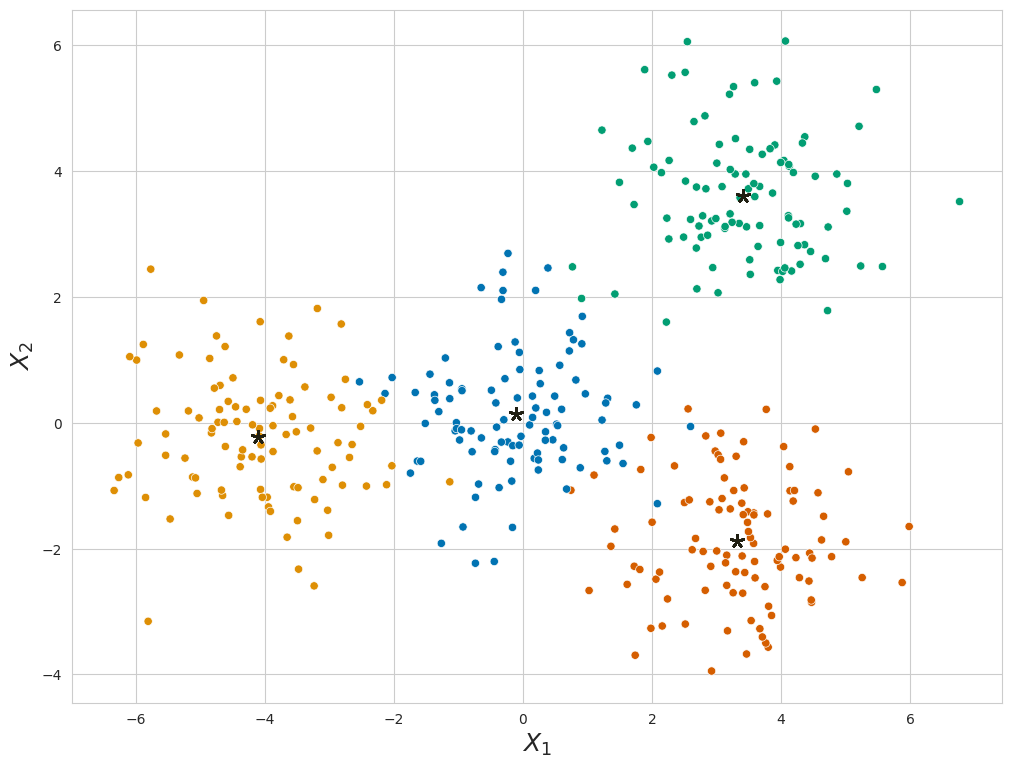

In [60]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [61]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        distances = np.zeros(shape=(X.shape[0], len(self.centroids)))
        print(distances)
        
        for i in range(len(self.centroids)):
            distances[:, i] = self._calculate_distance(X, self.centroids[i]).transpose()
        
        cluster_labels = np.argmin(distances, axis=1)
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = np.power(np.sum(np.power(X-centroid, 2), axis=1), 1/2)
        dist = np.reshape(dist, (-1, 1))
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

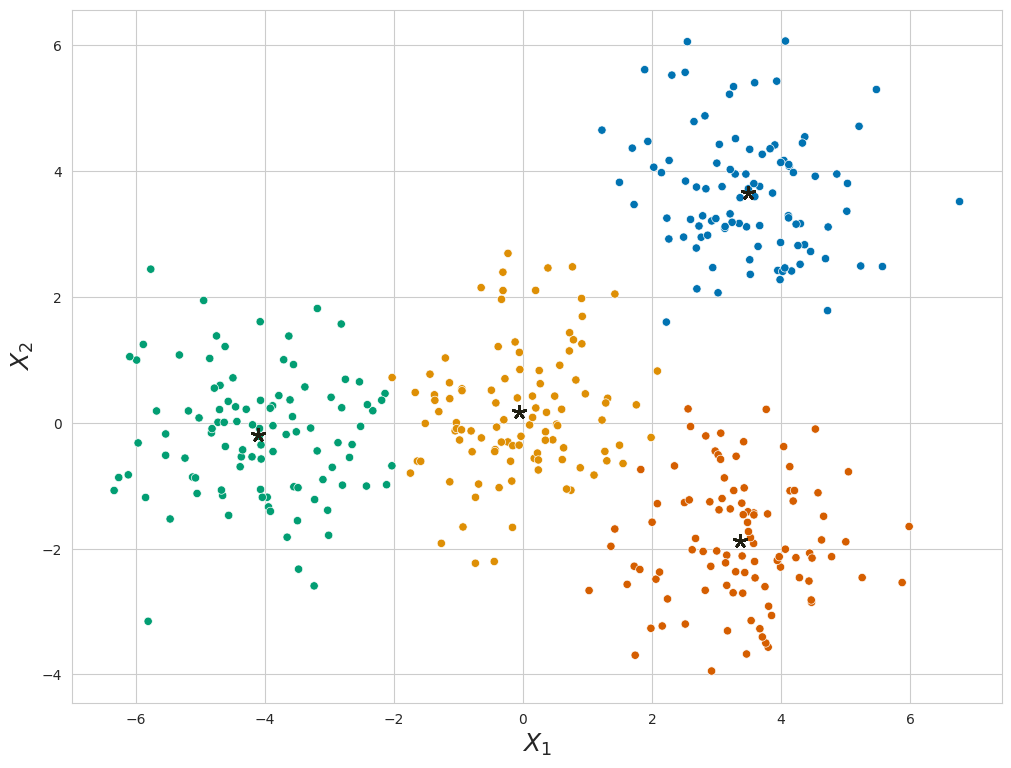

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [62]:
km = MyKMeans(n_clusters=4, max_iter=10, visualize=True, init='random')
km.fit(X)

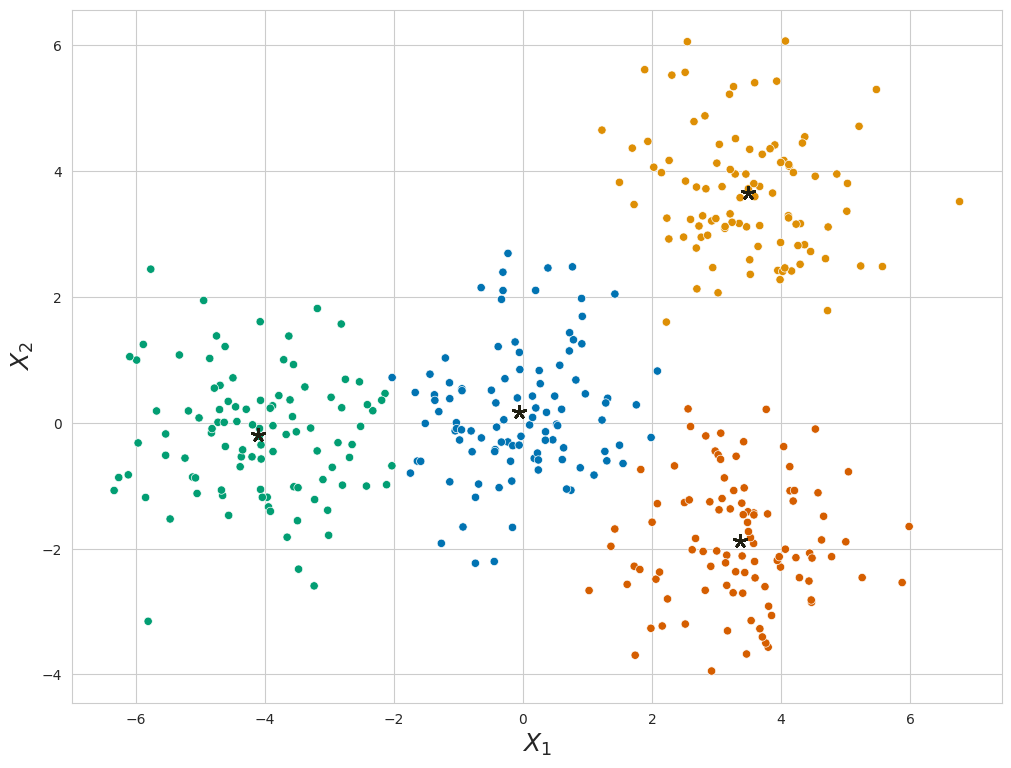

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [63]:
km = MyKMeans(n_clusters=4, max_iter=10, visualize=True, init='sample')
km.fit(X)

Результаты идентичны. 

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [69]:
data = load_digits()
X, y = data.data, data.target

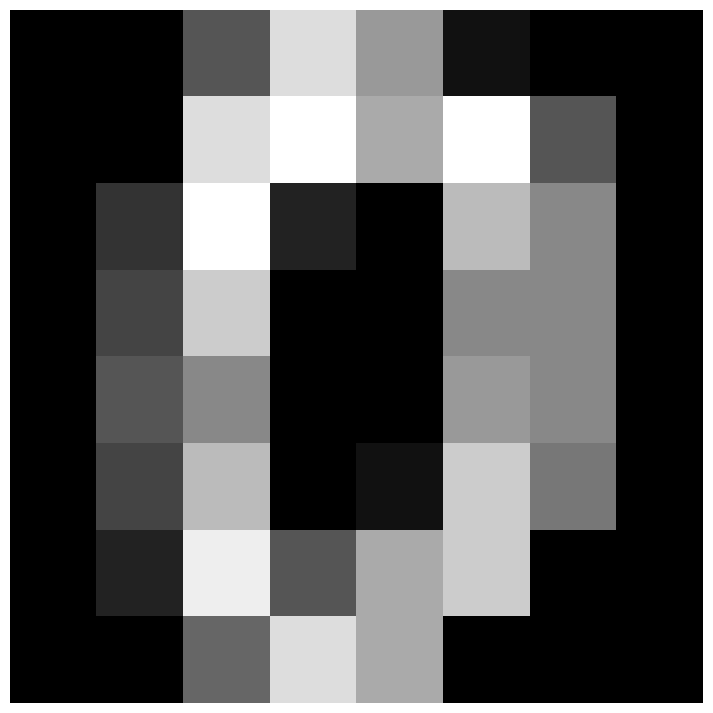

In [70]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [71]:
from sklearn.metrics.pairwise import cosine_distances

In [72]:
def algorithm_selection(X, y, distances, algorithms, metrics, clusters=2):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    
    dd = {'euclidean' : DistanceMetric.get_metric('euclidean').pairwise,
          'manhattan' : DistanceMetric.get_metric('manhattan').pairwise,
          'chebyshev' : DistanceMetric.get_metric('chebyshev').pairwise,
          'minkowski' : DistanceMetric.get_metric('minkowski').pairwise,
          'cosine' : cosine_distances}
    
    me = {'homogenity' : homogeneity_score,
          'completeness' : completeness_score,
          'v_measure' : v_measure_score,
          'silhouette' : silhouette_score}
    
    compare_dataframe = pd.DataFrame(columns = ["distance", "linkage", 
                             "homogenity","completeness",
                             "v_measure", "silhouette"])
    row = 0
    
    for i in distances:
        for j in algorithms:
            
            compare_dataframe.loc[row, 'distance'] = i
            compare_dataframe.loc[row, 'linkage'] = j
            
            dist = dd[i](X)
            
            agg = AgglomerativeClustering(n_clusters = clusters, linkage = j, metric = 'precomputed')
            result = agg.fit_predict(dist)
            
            for m in metrics:
                if m == 'silhouette':
                     compare_dataframe.loc[row, m] = me[m](X, result)
                else:
                    compare_dataframe.loc[row, m] = me[m](y, result)
            
            row += 1
    
    compare_dataframe = compare_dataframe.sort_values(by='silhouette', ascending=False)
    
    return compare_dataframe

In [73]:
distances = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'cosine']
algorithms = ['complete', 'single', 'average']
metrics = ['homogenity', 'completeness', 'v_measure', 'silhouette']
algorithm_selection(X, y, distances, algorithms, metrics, clusters=len(np.unique(y)))

distance   linkage homogenity completeness v_measure silhouette
8   chebyshev   average   0.769464     0.828645  0.797959     0.1739
2   euclidean   average   0.655393     0.782342  0.713263   0.146625
11  minkowski   average   0.655393     0.782342  0.713263   0.146625
3   manhattan  complete   0.646372     0.686109  0.665648   0.140183
14     cosine   average   0.648268     0.808762  0.719676   0.129526
0   euclidean  complete   0.590549     0.637772  0.613253   0.119271
9   minkowski  complete   0.590549     0.637772  0.613253   0.119271
5   manhattan   average   0.566751     0.778942  0.656117   0.089217
12     cosine  complete   0.528727     0.577415  0.551999   0.088021
7   chebyshev    single   0.006129      0.28143  0.011996   -0.08726
1   euclidean    single   0.005056     0.273755  0.009929  -0.133621
10  minkowski    single   0.005056     0.273755  0.009929  -0.133621
13     cosine    single    0.00505     0.273389  0.009916   -0.15825
4   manhattan    single   0.005102     0.276237  0.010019  -0.166627
6   chebyshev  complete   0.067111     0.412582  0.115444  -0.193835

Лучше всего себя показало сочетание chebyshev distance + average linkage	

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [3]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [4]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [5]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


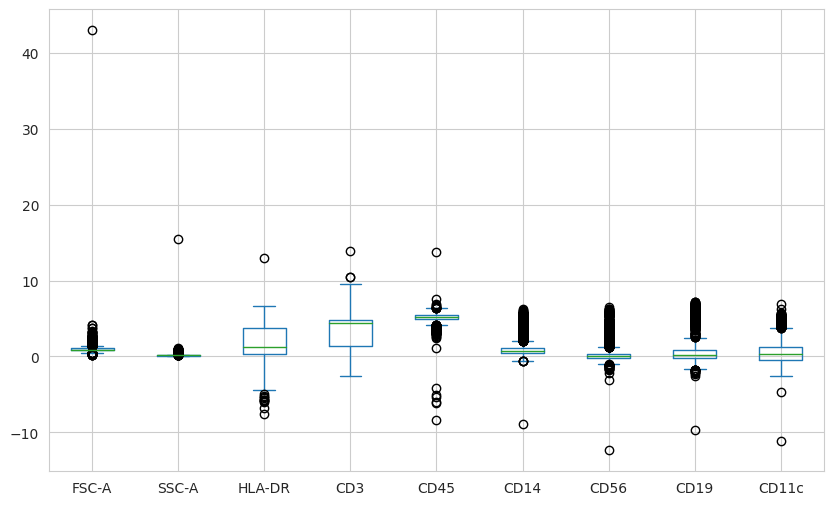

In [6]:
df = fc_data
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
features = list(df.columns[:])
df[features].plot.box(ax=ax1)
plt.show()

Пропущенные значения отсуствуют. Есть множество выбросов. Все фичи численные. Значения различных фичей отличаются на порядки, данные не стандартизованы

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [4]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

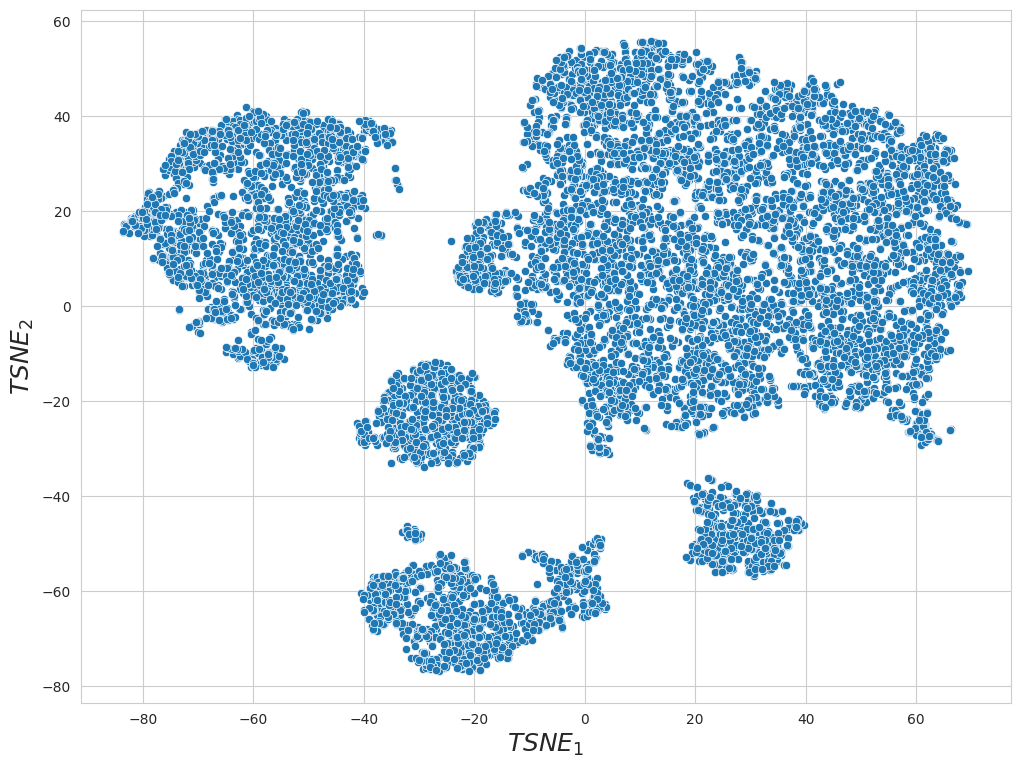

In [21]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Стандартизуем наши данные

In [5]:
col_names = fc_data.columns

preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), col_names),
])

sc_fc_data = preprocessor.fit_transform(fc_data)
sc_fc_data = pd.DataFrame(sc_fc_data)

Напишем функцию, которая будет рассчитывать silhouette_score для множества различных параметров трех изученных алгоритмов кластеризации

In [6]:
def algorithm_selection_2(X, distances, algorithms_agg, algorithms_km, init_km=['k-means++'], clusters=2, n_init_km=10, max_iter_km=300):

    dd = {'euclidean' : DistanceMetric.get_metric('euclidean').pairwise,
          'manhattan' : DistanceMetric.get_metric('manhattan').pairwise,
          'chebyshev' : DistanceMetric.get_metric('chebyshev').pairwise,
          'minkowski' : DistanceMetric.get_metric('minkowski').pairwise,
          'cosine' : cosine_distances}
    
    compare_dataframe = pd.DataFrame(columns = ['algotithm', "distance", "linkage_agg", 'alg_km', 
                                                'init_km', 'eps_db', 'min_smpls_db',
                                                'silhouette'])
    row = 0
    
    #AgglomerativeClustering
    
    for i in distances:
        for j in algorithms_agg:
            compare_dataframe.loc[row, 'algotithm'] = 'AgglomerativeClustering'
            compare_dataframe.loc[row, 'distance'] = i
            compare_dataframe.loc[row, 'linkage_agg'] = j
            
            dist = dd[i](X)
            
            agg = AgglomerativeClustering(n_clusters = clusters, linkage = j, metric = 'precomputed')
            result = agg.fit_predict(dist)
            
            compare_dataframe.loc[row, 'silhouette'] = silhouette_score(X, result)
            print('ac', i, j, compare_dataframe.loc[row, 'silhouette'], sep=' ')
            row += 1
    
    #k_means
    
    for i in algorithms_km:
        for j in init_km:
            compare_dataframe.loc[row, 'algotithm'] = 'k_means'
            compare_dataframe.loc[row, 'alg_km'] = i
            compare_dataframe.loc[row, 'init_km'] = j

            km = KMeans(n_clusters=clusters, max_iter=max_iter_km, 
                        n_init=n_init_km, algorithm=i, init=j)

            result = km.fit_predict(X)

            compare_dataframe.loc[row, 'silhouette'] = silhouette_score(X, result)
            
            print('km', i, j, compare_dataframe.loc[row, 'silhouette'], sep=' ')
            
            row += 1
            
        
    
    #DBSCAN
    
    for i in distances:
        for j in np.linspace(1, 5, 21):
            for m in np.arange(5, 50, 5):
                compare_dataframe.loc[row, 'algotithm'] = 'DBSCAN'
                compare_dataframe.loc[row, 'distance'] = i
                compare_dataframe.loc[row, 'eps_db'] = j
                compare_dataframe.loc[row, 'min_smpls_db'] = m

                dist = dd[i](X)

                db = DBSCAN(eps=j, metric = 'precomputed', min_samples=m, n_jobs=4)
                result = db.fit_predict(dist)

                if len(np.unique(result)) == 1:
                    compare_dataframe.loc[row, 'silhouette'] = np.NaN
                else:
                    compare_dataframe.loc[row, 'silhouette'] = silhouette_score(X, result)
                    
                print('db', i, j, m, compare_dataframe.loc[row, 'silhouette'], sep=' ')

                row += 1
        
    compare_dataframe = compare_dataframe.sort_values(by='silhouette', ascending=False)
    
    return compare_dataframe

Пытаемся использовать функцию и получить датафрейм с алгоритмами кластеризации и их гиперпараметрами.

In [ ]:
distances = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'cosine']
algorithms_agg = ['complete', 'single', 'average']
algorithms_km = ['lloyd', 'elkan']
init_km = ['k-means++', 'random']
res_df = algorithm_selection_2(sc_fc_data, distances, algorithms_agg=algorithms_agg, 
                      algorithms_km=algorithms_km,
                      clusters=4, init_km =init_km)
res_df

ac euclidean complete 0.3017100563394206
ac euclidean single 0.8404797300204473
ac euclidean average 0.8404797300204473
ac manhattan complete 0.4334049809413018
ac manhattan single 0.8404797300204473
ac manhattan average 0.8404797300204473
ac chebyshev complete 0.39679870023453884
ac chebyshev single 0.8404797300204473
ac chebyshev average 0.6053625886753269
ac minkowski complete 0.3017100563394206
ac minkowski single 0.8404797300204473
ac minkowski average 0.8404797300204473
ac cosine complete 0.5228562816947049
ac cosine single -0.35641778370355004
ac cosine average 0.5194532511262488
km lloyd k-means++ 0.5010743968681938
km lloyd random 0.5480553520093867
km elkan k-means++ 0.5010743968681938
km elkan random 0.548236181398487
db euclidean 1.0 5 0.3618861317409974
db euclidean 1.0 10 0.4269506198946824
db euclidean 1.0 15 0.4694485030235469
db euclidean 1.0 20 0.4662893731697416
db euclidean 1.0 25 0.45979156889540834
db euclidean 1.0 30 0.4540131659619232
db euclidean 1.0 35 0.45121

db euclidean 4.800000000000001 45 0.9051502684567182
db euclidean 5.0 5 0.9051502684567182
db euclidean 5.0 10 0.9051502684567182
db euclidean 5.0 15 0.9051502684567182
db euclidean 5.0 20 0.9051502684567182
db euclidean 5.0 25 0.9051502684567182
db euclidean 5.0 30 0.9051502684567182
db euclidean 5.0 35 0.9051502684567182
db euclidean 5.0 40 0.9051502684567182
db euclidean 5.0 45 0.9051502684567182
db manhattan 1.0 5 -0.40299340748142154
db manhattan 1.0 10 -0.31749508699649576
db manhattan 1.0 15 -0.23850714630228054
db manhattan 1.0 20 -0.17361102597698813
db manhattan 1.0 25 -0.2950849450684149
db manhattan 1.0 30 -0.2795178621574188
db manhattan 1.0 35 -0.3519133675987214
db manhattan 1.0 40 -0.32346426001516354
db manhattan 1.0 45 -0.32346426001516354
db manhattan 1.2 5 -0.25689548278639995
db manhattan 1.2 10 0.09045719539588179
db manhattan 1.2 15 0.08776485686525494
db manhattan 1.2 20 0.051098404206844666
db manhattan 1.2 25 0.03686938704573595
db manhattan 1.2 30 0.004353023

db manhattan 5.0 30 0.7604325072587188
db manhattan 5.0 35 0.7548360483747427
db manhattan 5.0 40 0.7498698324005674
db manhattan 5.0 45 0.7397657854009793
db chebyshev 1.0 5 0.4600201777693859
db chebyshev 1.0 10 0.469270879574269
db chebyshev 1.0 15 0.5003282451602233
db chebyshev 1.0 20 0.5001997938848708
db chebyshev 1.0 25 0.5000767830531317
db chebyshev 1.0 30 0.4999451527800452
db chebyshev 1.0 35 0.49989458021842703
db chebyshev 1.0 40 0.49915831909467995
db chebyshev 1.0 45 0.49909761790607554
db chebyshev 1.2 5 0.7246120222232117
db chebyshev 1.2 10 0.6884764063677933
db chebyshev 1.2 15 0.6632179475354626
db chebyshev 1.2 20 0.6211088041559837
db chebyshev 1.2 25 0.6063533895719811
db chebyshev 1.2 30 0.598832136296457
db chebyshev 1.2 35 0.5891756062787128
db chebyshev 1.2 40 0.5836639761114227
db chebyshev 1.2 45 0.582497266385353
db chebyshev 1.4 5 0.8109168610259326
db chebyshev 1.4 10 0.7865559684695161
db chebyshev 1.4 15 0.7438223791757872
db chebyshev 1.4 20 0.743822

db minkowski 1.0 30 0.4540131659619232
db minkowski 1.0 35 0.4512111860261434
db minkowski 1.0 40 0.4496220790570689
db minkowski 1.0 45 0.4762134536867203
db minkowski 1.2 5 0.42588032142045806
db minkowski 1.2 10 0.3971061969390357
db minkowski 1.2 15 0.42303584727548266
db minkowski 1.2 20 0.4533703187663601
db minkowski 1.2 25 0.489055083280344
db minkowski 1.2 30 0.48587931217190156
db minkowski 1.2 35 0.485195731457851
db minkowski 1.2 40 0.5172970140692935
db minkowski 1.2 45 0.5155310339247964
db minkowski 1.4 5 0.4697955800734024
db minkowski 1.4 10 0.46890029515251846
db minkowski 1.4 15 0.49797992758825405
db minkowski 1.4 20 0.49768069184089564
db minkowski 1.4 25 0.43532960665440734
db minkowski 1.4 30 0.49525030227759154
db minkowski 1.4 35 0.49520552233374193
db minkowski 1.4 40 0.49418032764419023
db minkowski 1.4 45 0.4934528731902339
db minkowski 1.6 5 0.5015388597390852
db minkowski 1.6 10 0.469846917314613
db minkowski 1.6 15 0.5009944765174589
db minkowski 1.6 20 0

db cosine 1.4 45 nan
db cosine 1.6 5 nan
db cosine 1.6 10 nan
db cosine 1.6 15 nan
db cosine 1.6 20 nan
db cosine 1.6 25 nan
db cosine 1.6 30 nan
db cosine 1.6 35 nan
db cosine 1.6 40 nan
db cosine 1.6 45 nan
db cosine 1.8 5 nan
db cosine 1.8 10 nan
db cosine 1.8 15 nan
db cosine 1.8 20 nan
db cosine 1.8 25 nan
db cosine 1.8 30 nan
db cosine 1.8 35 nan
db cosine 1.8 40 nan
db cosine 1.8 45 nan
db cosine 2.0 5 nan
db cosine 2.0 10 nan
db cosine 2.0 15 nan
db cosine 2.0 20 nan
db cosine 2.0 25 nan
db cosine 2.0 30 nan
db cosine 2.0 35 nan
db cosine 2.0 40 nan
db cosine 2.0 45 nan
db cosine 2.2 5 nan
db cosine 2.2 10 nan
db cosine 2.2 15 nan
db cosine 2.2 20 nan
db cosine 2.2 25 nan
db cosine 2.2 30 nan
db cosine 2.2 35 nan
db cosine 2.2 40 nan
db cosine 2.2 45 nan
db cosine 2.4000000000000004 5 nan
db cosine 2.4000000000000004 10 nan
db cosine 2.4000000000000004 15 nan
db cosine 2.4000000000000004 20 nan
db cosine 2.4000000000000004 25 nan
db cosine 2.4000000000000004 30 nan
db cosine 2.

Именно что пытаемся. Мощности моего компьютера оказалось недостаточно для рассчета всего, что хотелось проверить. Тем не менее, максимальный silhouette_score из полученных составил 0.9051502684567182 для алгоритма DBSCAN, что кажется очень очень хорошим резульататом, однако на деле таковым не является.

db dist=euclidean eps=5.0 min_s=5 silhouette_score=0.9051502684567182

In [31]:
dist = DistanceMetric.get_metric('euclidean').pairwise(sc_fc_data)

db = DBSCAN(eps=5.0, metric = 'precomputed', min_samples=5, n_jobs=4)
result = db.fit_predict(dist)

silhouette_score(sc_fc_data, result)

0.9051502684567182

array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

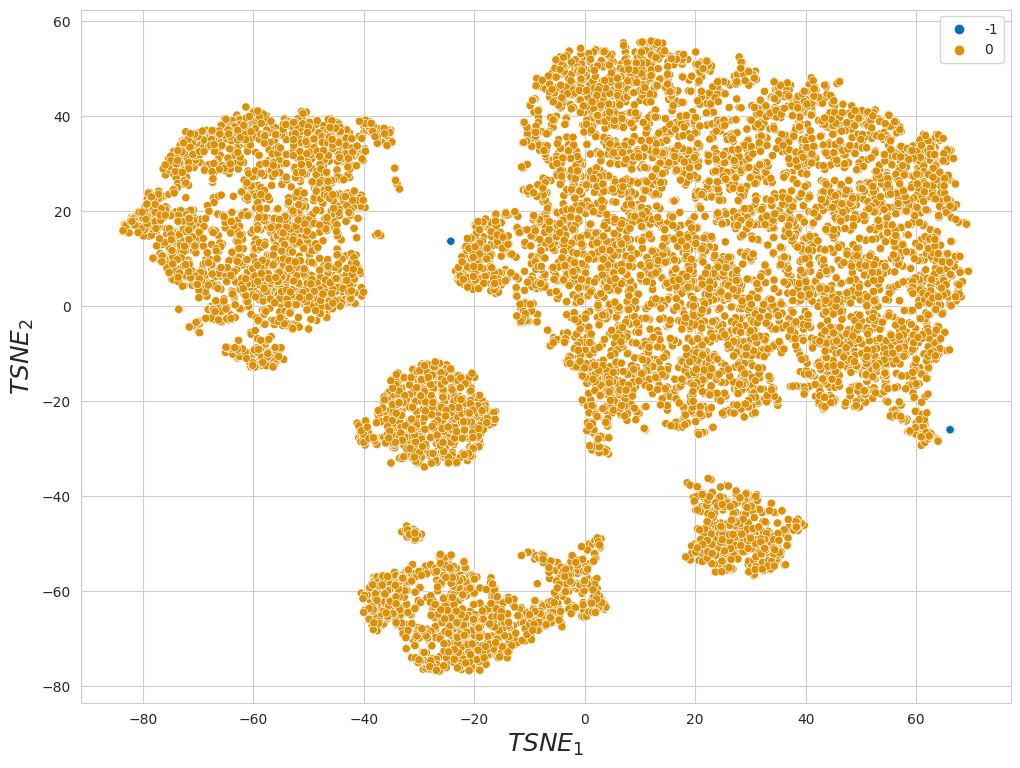

In [32]:
plot_tsne(fc_data, color=result)

Все объекты окказались в одном кластере

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

С помощью DBSCAN - относительно рабочие гиперпараметры для кластеризации найдены уже ручным перебором. Тем не менее, они явно не оптимальные. Остается множество объектов, не отнесенных ни к одному кластеру.

0.5191646507630403


array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

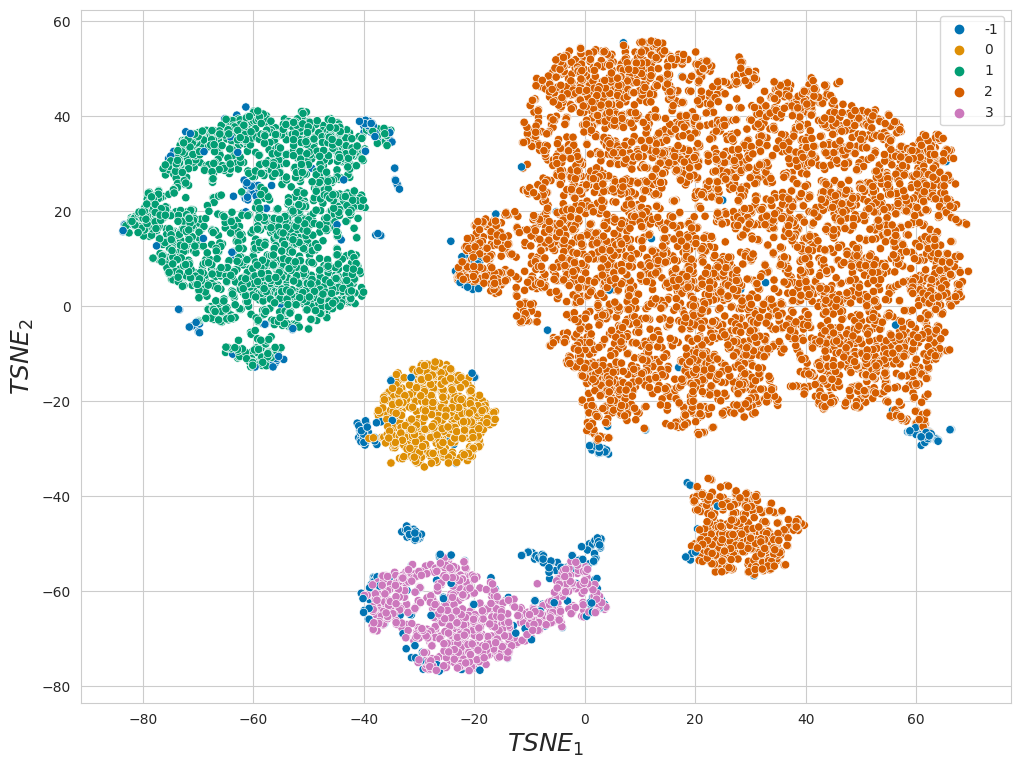

In [34]:
db = DBSCAN(eps=1.15, min_samples=24)
db_result = db.fit_predict(sc_fc_data)
print(silhouette_score(sc_fc_data, db_result))
plot_tsne(fc_data, color=db_result)

Используем алгоритм AgglomerativeClustering. Подобранные ранее варианты гиперпараметров, дающие высший silhouette_score, также сбрасывают почти все объекты в 1 кластер. При стандартных параметрах же - получаются лучшие результаты, однако и с ними не удается полноценно выделить последний кластер.

0.49863676583904437


array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

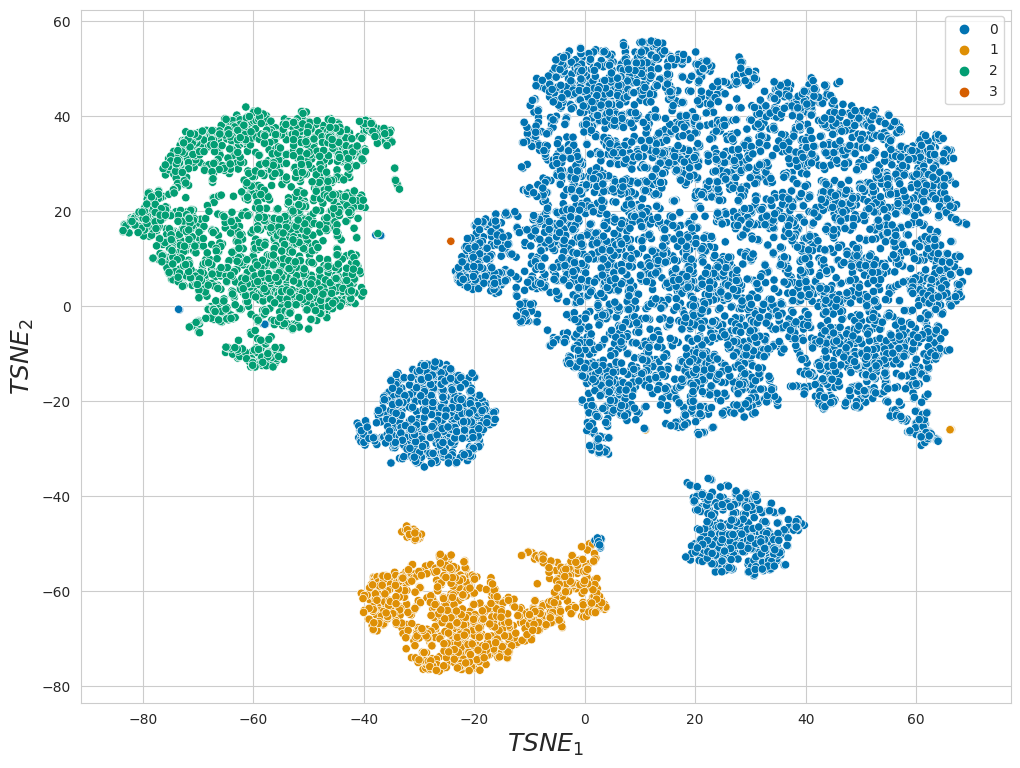

In [36]:
agg = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
agg_result = agg.fit_predict(sc_fc_data)
print(silhouette_score(sc_fc_data, agg_result))
plot_tsne(fc_data, color=agg_result)

Лучшие результаты k_mean получены со следующими гиперпараметрами: elkan random. silhouette_score=0.548236181398487. Один из субкластеров разделился на 2 половины, принадлежащие разным кластерам.

0.5480553520093867


array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

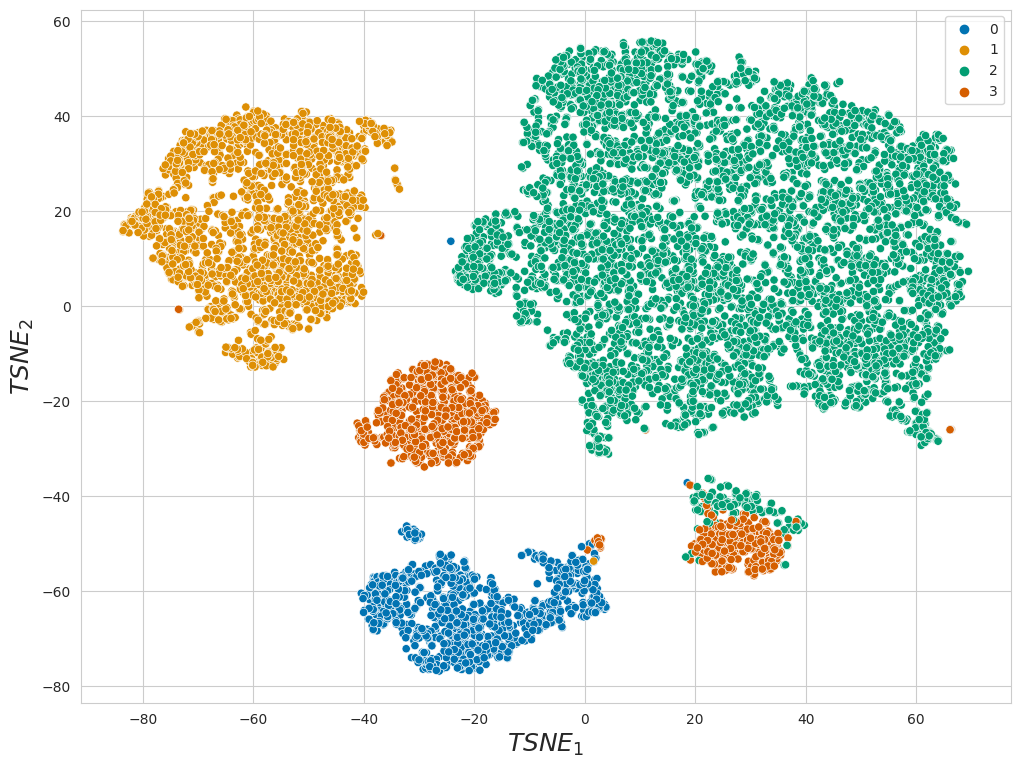

In [37]:
km = KMeans(n_clusters=4, algorithm='elkan', init='random')
km_result = km.fit_predict(sc_fc_data)
print(silhouette_score(sc_fc_data, km_result))
plot_tsne(fc_data, color=km_result)

Как итог, лучше всего сработали алгоритмы DBSCAN и KMeans. Скорее всего, для первого можно подобрать гиперпараметры так, что результат будет значительно лучше. Параметр silhouette_score выше в случае KMeans, но после описанного выше он не внушает доверия... В дальнейшем будем пользоваться DBSCAN, так как лучше оставить в стороне часть клеток, нежели отнести их к неверному типу, на мой взгляд.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

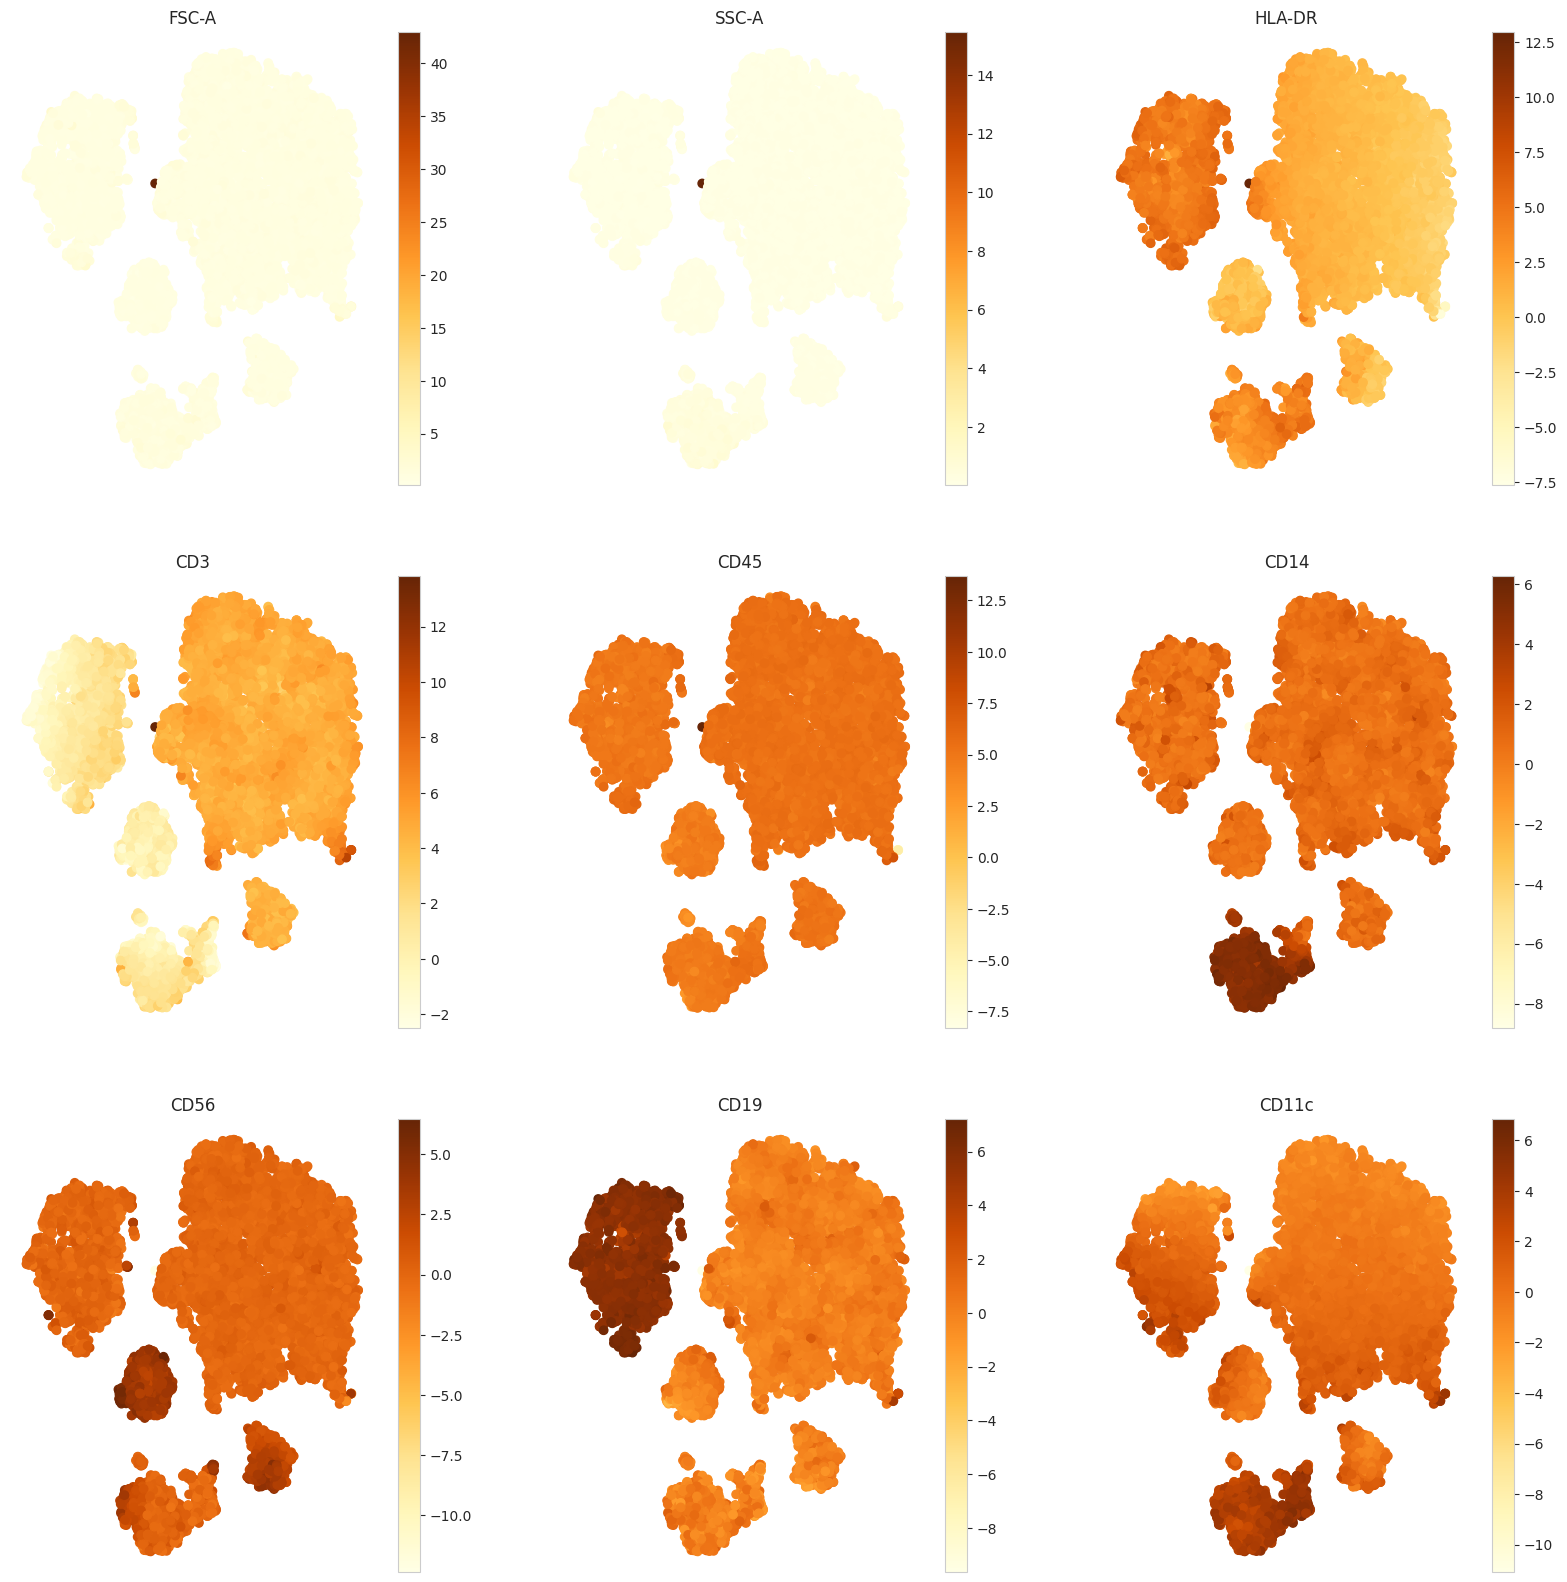

In [22]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [44]:
cell_type_cluster_map = {-1: "[DATA EXPUNGED]",
                         0: "Other cells", 
                         1: "B cells", 
                         2: "T cells", 
                         3: "Monocytes"}

In [45]:
labeled_fc_data = fc_data.assign(Population=db_result)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [46]:
labeled_fc_data["Population"].value_counts()

T cells            6100
B cells            1899
Monocytes           887
Other cells         588
[DATA EXPUNGED]     526
Name: Population, dtype: int64

In [47]:
labeled_fc_data["Population"].value_counts(normalize=True) * 100

T cells            61.00
B cells            18.99
Monocytes           8.87
Other cells         5.88
[DATA EXPUNGED]     5.26
Name: Population, dtype: float64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [48]:
labeled_fc_data.to_csv('labeled_fc_data.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Никуда бы не хотел, на самом деле. Лучше бы посидел дома в тепле и поглазел в потолок.

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Первая половина показалась простой. Вторая - посложнее, но тоже норм, однако времени я на нее убил знатно. Но было интересно. Расстроился, когда увидел, что вариант с лучшим silhouette_score, который подбирался часа 3, оказался пустышкой...